---
title: STAC-Based Exploration and Visualization of Sentinel-1 and Sentinel-2 Data
subtitle: Learn how to access Sentinel-1 and Sentinel-2 images using STAC metadata using pystac client
authors:
  - name: Suriyah Dhinakaran
    orcid: 0009-0007-0355-7372
    github: suriyahgit
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
  - name: Michele Claus
    orcid: 0000-0003-3680-381X
    github: clausmichele
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
date: 2025-06-16
thumbnail: https://raw.githubusercontent.com/EOPF-Sample-Service/eopf-sample-notebooks/refs/heads/main/notebooks/static/ESA_logo_2020_Deep.png
keywords: ["xarray", "gdal", "earth observation", "remote sensing"]
tags: ["sentinel-2", "xarray", "gdal"]
releaseDate: 2025-06-16
datePublished: 2025-06-16
dateModified: 2025-06-16
---

```{image} ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
:alt: ESA EOPF Zarr Logo
:width: 250px
:align: center
```

## Table of Contents

1. [Introduction](#Introduction)  
2. [Setup](#Setup)  
3. [STAC Collection Discovery](#STAC-Collection-Discovery)  
4. [Sentinel-2 Item Search](#Sentinel-2-Item-Search)  
5. [Visualization Function for Sentinel-2](#Visualization-Function-for-Sentinel-2)  
6. [Sentinel-1 GRD Item Search (Simple Query)](#Sentinel-1-GRD-Item-Search-Simple-Query)  
7. [Sentinel-1 GRD Data Loading and Visualization](#Sentinel-1-GRD-Data-Loading-and-Visualization) 

## Introduction

This notebook provides a comprehensive walkthrough for accessing, filtering, and visualizing Sentinel-1 and Sentinel-2 satellite imagery using a STAC (SpatioTemporal Asset Catalog) interface. Leveraging the pystac-client, xarray, and matplotlib libraries, the notebook demonstrates how to:

1. Connect to a public EOPF STAC catalog hosted at https://stac.core.eopf.eodc.eu.

2. Perform structured searches across Sentinel-2 L2A and Sentinel-1 GRD collections, filtering by spatial extent, date range, cloud cover, and orbit characteristics.

3. Retrieve and load data assets directly into xarray for interactive analysis.

4. Visualize Sentinel-2 RGB composites along with pixel-level cloud coverage masks.

5. Render Sentinel-1 backscatter data (e.g., VH polarization) for selected acquisitions.


::: {hint} Overview
**Questions**

* How can Sentinel-1 and Sentinel-2 data be searched and accessed using a STAC API?
* How can we visualize RGB imagery and cloud cover from Sentinel-2 L2A data?
* What techniques are effective for loading and displaying Sentinel-1 GRD data with Xarray?
* How can we use metadata filters (e.g., cloud cover, orbit state) to refine STAC queries?

**Objectives**

* Demonstrate how to connect to and query a STAC catalog hosted at `core.eopf.eodc.eu`.
* Show how to visualize Sentinel-2 L2A imagery using RGB composites and cloud masks.
* Explain how to access, load, and render Sentinel-1 SAR (VH polarization) data from STAC assets.
* Use advanced STAC query parameters to filter satellite scenes based on cloud coverage, time range, and orbit characteristics.
* Provide reusable code for STAC-driven workflows in Earth observation analytics.
:::

## Setup

Start importing the necessary libraries

In [1]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pystac_client
import xarray as xr
from pystac_client import CollectionSearch
from matplotlib.gridspec import GridSpec

## STAC Collection Discovery

Using CollectionSearch to list available STAC collections

In [2]:
# Initialize the collection search
search = CollectionSearch(
    url="https://stac.core.eopf.eodc.eu/collections",  # STAC /collections endpoint
)

# Retrieve all matching collections (as dictionaries)
for collection_dict in search.collections_as_dicts():
    print(collection_dict["id"])

sentinel-2-l2a
sentinel-3-slstr-l1-rbt
sentinel-3-olci-l2-lfr
sentinel-2-l1c
sentinel-3-slstr-l2-lst
sentinel-1-l1-slc
sentinel-3-olci-l1-efr
sentinel-3-olci-l1-err
sentinel-1-l2-ocn
sentinel-1-l1-grd
sentinel-3-olci-l2-lrr


/home/sdhinakaran/micromamba/envs/new_eopf/lib/python3.11/site-packages/pystac_client/collection_search.py:121: PystacClientWarning: Unable to parse extent from collection=sentinel-3-olci-l2-lrr
  warnings.warn(


## Sentinel-2 Item Search

Querying the Sentinel-2 L2A collection by bounding box, date range, and cloud cover

In [3]:
catalog = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")
# Search with cloud cover filter
items = list(
    catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=[7.2, 44.5, 7.4, 44.7],
        datetime=["2025-01-30", "2025-05-01"],
        query={"eo:cloud_cover": {"lt": 20}},  # Cloud cover less than 20%
    ).items()
)
print(items)

[<Item id=S2B_MSIL2A_20250430T101559_N0511_R065_T32TLQ_20250430T131328>, <Item id=S2C_MSIL2A_20250425T102041_N0511_R065_T32TLQ_20250425T155812>, <Item id=S2C_MSIL2A_20250418T103041_N0511_R108_T32TLQ_20250418T160655>, <Item id=S2C_MSIL2A_20250405T102041_N0511_R065_T32TLQ_20250405T175414>]


## Quicklook Visualization for Sentinel-2 

Here is the quicklook for the sentinel-2 using the reflectance at 60m bands

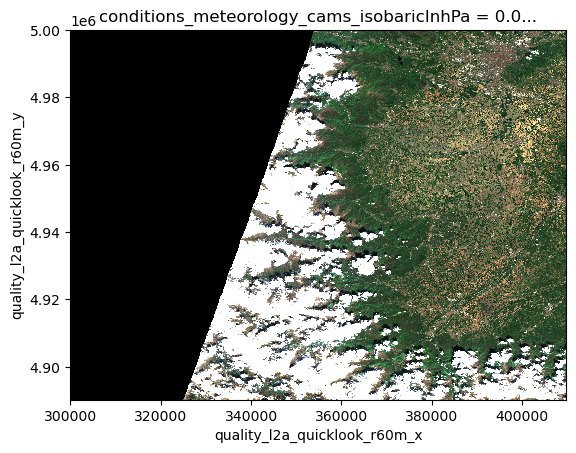

In [4]:
item = items[0]  # extracting the first item

ds = xr.open_dataset(
    item.assets["product"].href,
    **item.assets["product"].extra_fields["xarray:open_datatree_kwargs"],
)  # The engine="eopf-zarr" is already embedded in the STAC metadata

ds.quality_l2a_quicklook_r60m_tci.plot.imshow(rgb="quality_l2a_quicklook_r60m_band")

## Visualization Function for Sentinel-2

Function to display: Quicklook RGBs and SCL Visualisation for all the items

/tmp/ipykernel_1368121/3642808872.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


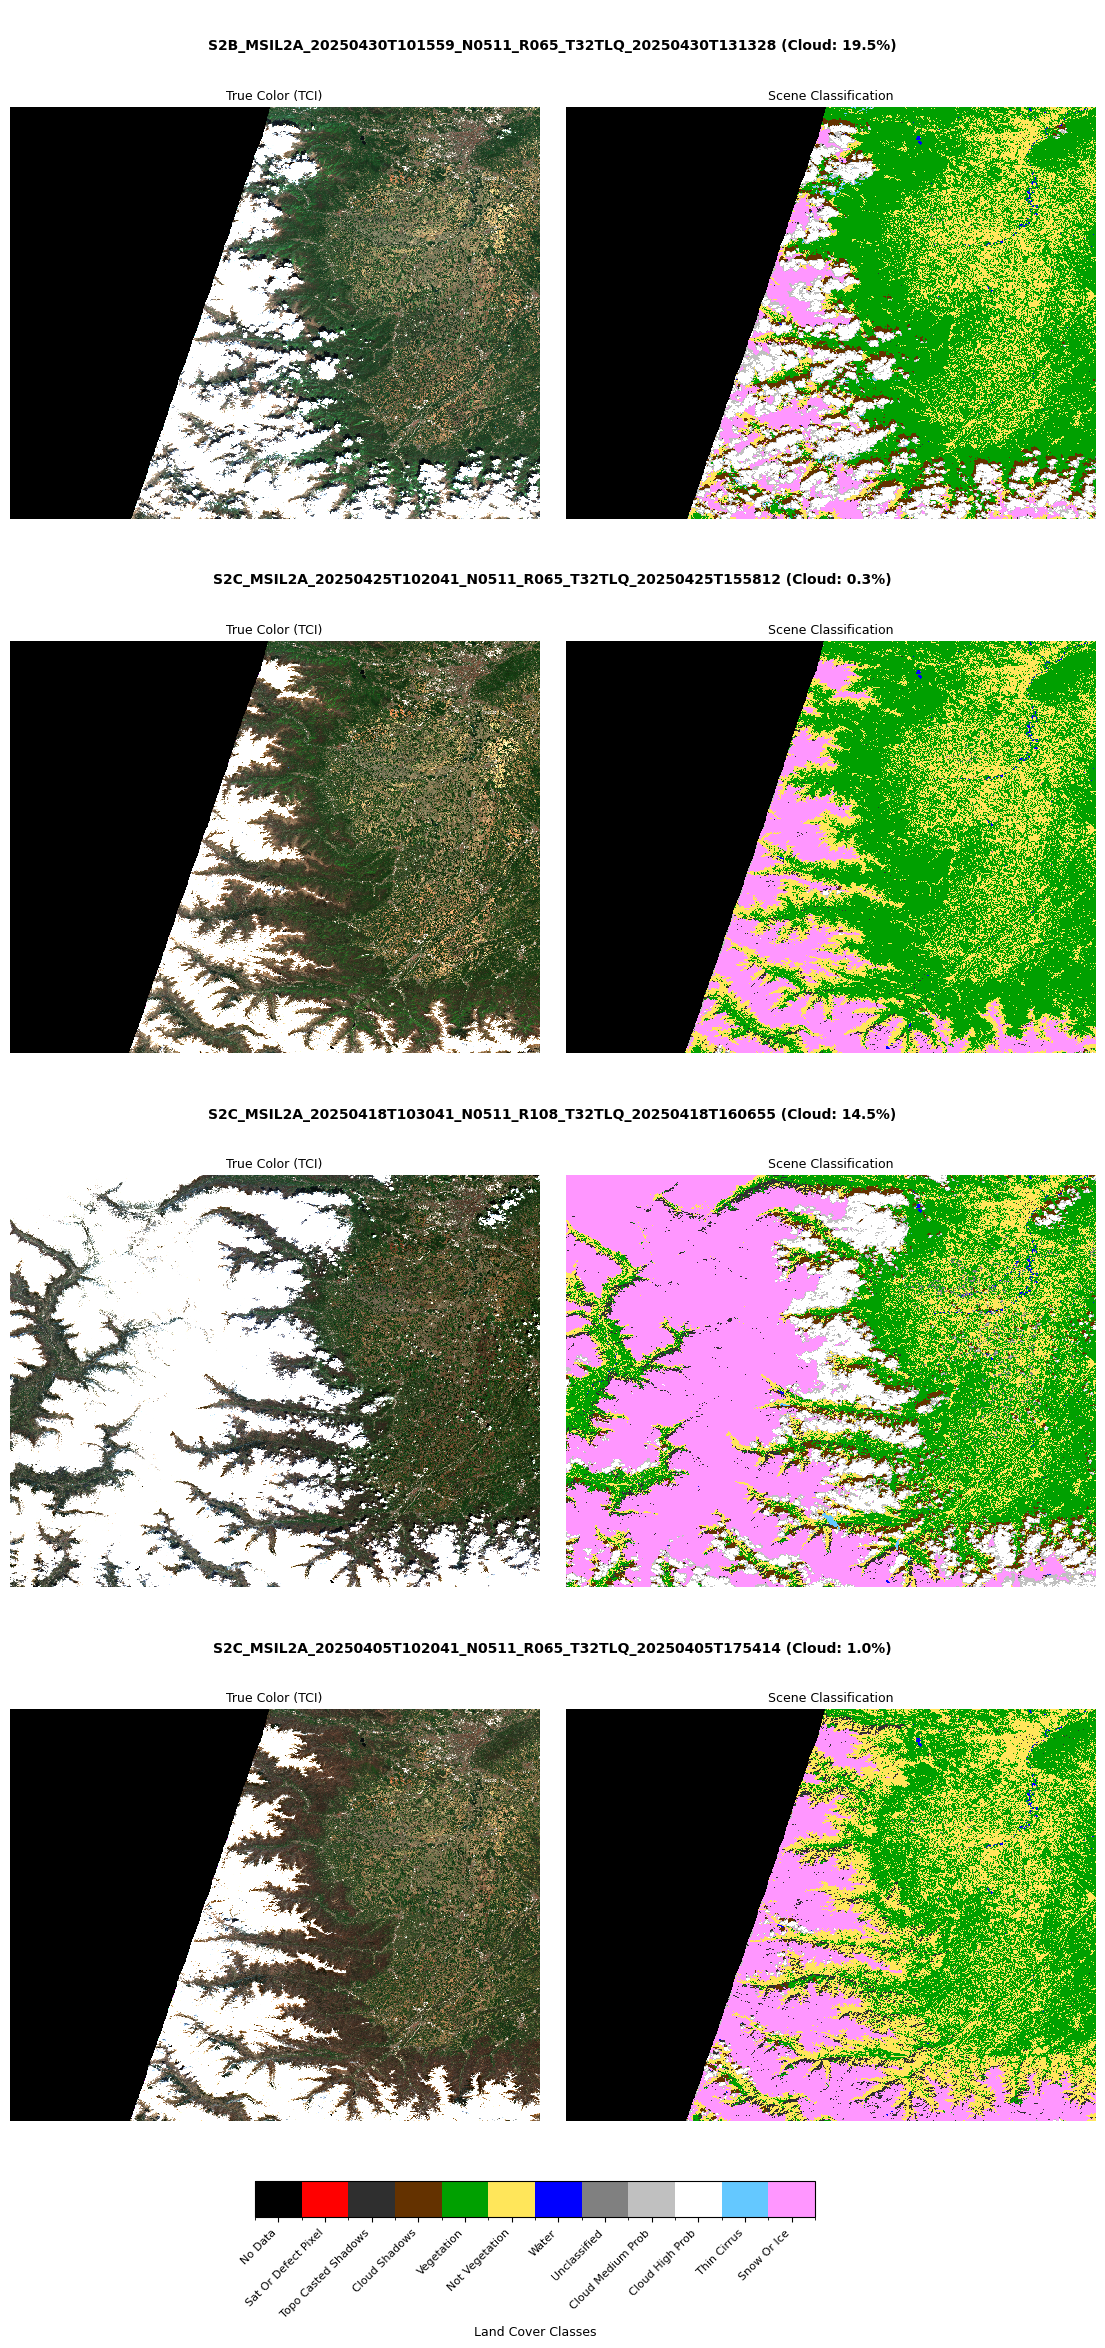

In [5]:
def visualize_items_table(items):
    """
    Visualize multiple Sentinel-2 items with scene IDs centered above each row,
    followed by two columns (RGB and SCL).

    Parameters:
        items (list): List of STAC items
    """
    num_items = len(items)
    row_height = 7  # Approximate height per item
    fig_height = min(row_height * num_items, 24)

    fig = plt.figure(figsize=(14, fig_height))

    # Create height ratios: 0.3 for title row, 1.7 for image row (per item)
    height_ratios = []
    for _ in range(num_items):
        height_ratios.extend([0.3, 1.7])  # first is title, second is images

    gs = GridSpec(
        num_items * 2, 2, height_ratios=height_ratios, hspace=0.1, wspace=0.05
    )

    # Create colorbar axis (positioned below all plots)
    scl_cbar_ax = fig.add_axes([0.3, 0.03, 0.4, 0.015])  # [left, bottom, width, height]

    for i, item in enumerate(items):
        try:
            # Add centered title for the row
            title_ax = fig.add_subplot(gs[i * 2, :])  # Span both columns
            title_text = f"{item.id} (Cloud: {item.properties['eo:cloud_cover']:.1f}%)"
            title_ax.text(
                0.5,
                0.5,
                title_text,
                ha="center",
                va="center",
                fontsize=10,
                fontweight="bold",
            )
            title_ax.axis("off")

            # Load the dataset
            ds = xr.open_dataset(
                item.assets["product"].href,
                **item.assets["product"].extra_fields["xarray:open_datatree_kwargs"],
            )

            # RGB Column
            ax1 = fig.add_subplot(gs[i * 2 + 1, 0])
            try:
                if "quality_l2a_quicklook_r60m_tci" in ds:
                    ds.quality_l2a_quicklook_r60m_tci.plot.imshow(ax=ax1)
                    ax1.set_title("True Color (TCI)", pad=5, fontsize=9)
                else:
                    ax1.text(
                        0.5,
                        0.5,
                        "No RGB quicklook",
                        ha="center",
                        va="center",
                        fontsize=8,
                    )
            except Exception as e:
                ax1.text(0.5, 0.5, f"RGB Error", ha="center", va="center", fontsize=8)
            ax1.axis("off")

            # SCL Column
            ax2 = fig.add_subplot(gs[i * 2 + 1, 1])
            try:
                if "conditions_mask_l2a_classification_r60m_scl" in ds:
                    scl = ds.conditions_mask_l2a_classification_r60m_scl.compute()

                    # Apply classification attributes
                    scl.attrs.update(
                        {
                            "flag_values": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
                            "flag_meanings": "no_data sat_or_defect_pixel topo_casted_shadows cloud_shadows vegetation not_vegetation water unclassified cloud_medium_prob cloud_high_prob thin_cirrus snow_or_ice",
                            "flag_colors": "#000000 #ff0000 #2f2f2f #643200 #00a000 #ffe65a #0000ff #808080 #c0c0c0 #ffffff #64c8ff #ff96ff",
                        }
                    )

                    cmap = mcolors.ListedColormap(scl.attrs["flag_colors"].split(" "))
                    norm = mcolors.BoundaryNorm(
                        boundaries=np.arange(13) - 0.5, ncolors=12  # For 12 classes
                    )

                    img_scl = scl.plot.imshow(
                        ax=ax2, cmap=cmap, norm=norm, add_colorbar=False
                    )
                    ax2.set_title("Scene Classification", pad=5, fontsize=9)

                    # Create colorbar once
                    if i == 0:
                        cbar = fig.colorbar(
                            img_scl,
                            cax=scl_cbar_ax,
                            orientation="horizontal",
                            ticks=np.arange(12),
                        )
                        class_labels = [
                            label.replace("_", " ").title()
                            for label in scl.attrs["flag_meanings"].split()
                        ]
                        cbar.ax.set_xticklabels(
                            class_labels, rotation=45, ha="right", fontsize=8
                        )
                        cbar.set_label("Land Cover Classes", fontsize=9)

                else:
                    ax2.text(
                        0.5, 0.5, "No SCL layer", ha="center", va="center", fontsize=8
                    )
            except Exception as e:
                ax2.text(0.5, 0.5, f"SCL Error", ha="center", va="center", fontsize=8)
            ax2.axis("off")

        except Exception as e:
            print(f"Error processing item {item.id}: {str(e)}")
            continue

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.07, top=0.95)  # Adjust for colorbar and titles
    plt.show()

visualize_items_table(items)

## Sentinel-1 GRD Item Search (Simple Query)

Querying Sentinel-1 L1 GRD collection for a small bounding box and orbit direction

In [6]:
# Load the STAC catalog
catalog = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")

# Search for Sentinel-1 GRD items matching the metadata characteristics
items = list(
    catalog.search(
        collections=["sentinel-1-l1-grd"],
        bbox=[29.922651, -9.648995, 32.569355, -7.391839],  # Same bbox as in metadata
        datetime=[
            "2025-06-09T16:19:07Z",
            "2025-06-09T16:19:40Z",
        ],  # Time range from metadata
        query={
            "sat:orbit_state": {"eq": "ascending"},  # From properties
            "sat:relative_orbit": {"eq": 174},  # From properties
        },
    ).items()
)
items

[<Item id=S1A_IW_GRDH_1SDV_20250609T161936_20250609T162001_059571_07655C_4E9C>,
 <Item id=S1A_IW_GRDH_1SDV_20250609T161907_20250609T161936_059571_07655C_0AB1>]

## Sentinel-1 GRD Data Loading and Visualization



Opening a selected Sentinel-1 dataset and plotting VH polarization

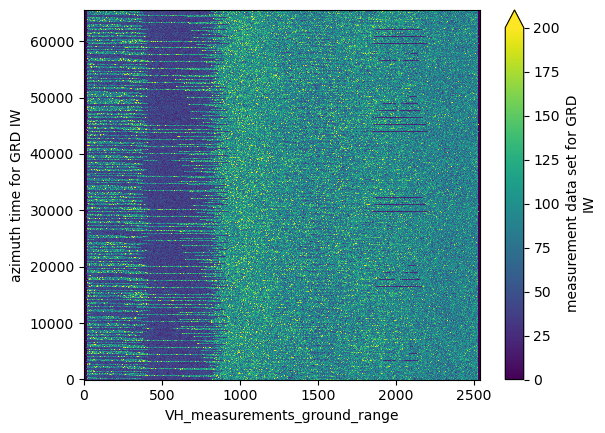

In [7]:
item = items[0]

ds = xr.open_dataset(
    item.assets["product"].href,
    **item.assets["product"].extra_fields["xarray:open_datatree_kwargs"],
    variables="VH_measurements*"
)

ds_sorted = ds["VH_measurements_grd"].sortby(["VH_measurements_azimuth_time"])
ds_sorted[::10, ::10].plot(vmax=200)

#### Reprocessing of the Sentinel-1 Pending for the data in STAC - Find the issue below

https://github.com/EOPF-Sample-Service/eopf-sample-data/issues/8#issuecomment-2976251107